<!-- <div style="text-align: center">
<img src="images.png" width="300px">
</div>
 -->
# Starting kit on Scene Recognize

Xinneng XU, Ziheng LI

1. [Introduction](#Introduction)
2. [Prediction Task](#Prediction-Task)
3. [The dataset](#The-dataset)
4. [Data Analysis](#Data-Analysis)
5. [Load Image Data](#Load-Image-Data)
6. [Data Preprocessing](Data-Preprocessing)
7. [Baseline Model](#Baseline-Model)
8. [Test Local Submission](#Test-Local-Submission)
9. [More Information](#More-Information)

# Introduction

Scene classification plays an important role in automated surveillance applications including pedestrian detection, indoor positioning, categorizing in semantic classes etc.

Automatic scene classification (sometimes referred to as scene recognition, or scene analysis) is a longstanding research problem in computer vision, which consists of assigning a label such as 'beach', 'bedroom', or simply 'indoor' or 'outdoor' to an image presented as input, based on the image's overall contents.

Scene classification is quite usful in our life. For example,using person/face recognition in conjunction with scene classification, one can predict the relationship between two detected people as enemies if they frequently co-occur in adversarial scenes, or friendly if they frequently co-occur in friendly scenes.


Scene classification is also an important part in many context. There are many applications of scene classification that contribute to its importance. For example, spatial context between detected objects, where the relative position of certain objects is constrained by the scene context in which they occur: a man rides a horse and not the other way round in an equestrian scene.

This kind of problem is sometimes difficult, because normally there are many scene in our life, and once we have learned a model, il can not do a good prediction if it hasn't seen a scene.

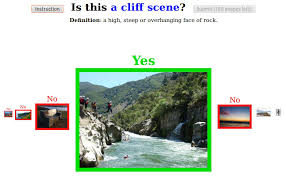


This challenge will focus on the scene classification, which is to learn a model then use the model to classifier the image into a class automately.

# Prediction Task

Using the computer vision to classifying the image into a class can accelerate many automated surveillance applications. The object of this challenge is to build a model which can classify the images automately into one of 6 scenes including forest, street, sea view etc.

<img src="https://qixianbiao.github.io/images/scene.jpg" width="70%">
<div style="text-align: center"> </div>

The quality of the prediction will be measured with a multi-class version of the F1-score. The better the prediction means the more image are classified. 

# The dataset
The dataset comes from the [inter_data_scene](https://www.kaggle.com/dipam7/intel-data-scene). You can download the full dataset by click [HERE](https://drive.google.com/file/d/1AT78aCthhWoNYRYQQXKUdz8jc2l5bzUd/view?usp=sharing).

The train dataset contains 11220 images and 6 classes. The labels of images are stored in a csv file which has two attributes: ``image_path``(string) which is the image name of each image and ``label``(int) which is the class of the image.



### References

1. N. Rasiwasia and N. Vasconcelos, “Holistic context modeling using semantic co-occurrences,” CVPR, 2009.
2. S. Lazebnik, C. Schmid, and J. Ponce, “Beyond bags of features: Spatial pyramid matching for recognizing natural scene categories,” CVPR, 2006.


### Required dependencies

All dependencies needed are written in `requirements.txt`, you can run the following command to install the dependencies if you don't have some dependencies. 

In [1]:
# !pip install -r requirements.txt

In [2]:
import numpy as np
from PIL import Image
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import transform
import torch.nn as nn
import torch.optim as optim
import torch as th
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import time
import itertools

import os


# Data Analysis

Read the dataset

In [3]:
train_data_label = pd.read_csv("data/train.csv")
test_data_label = pd.read_csv("data/test.csv")

In [4]:
train_data_label.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


There are 6 classes, the labels and their class names are as follows:

* prediction_label_names = [0, 1, 2, 3, 4, 5] 

* name = ["building", "forest", "snow scene","mountain", "sea view", "street"]

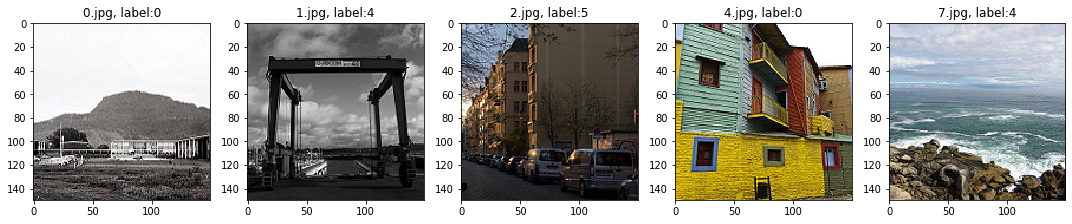

In [5]:
# Show the first 5 images

fig, axes = plt.subplots(ncols=5, figsize=(15, 3))
for i, idx in enumerate(train_data_label['image_name'][:5]):
    image_path = "data/train/"+str(idx)
    axes[i].imshow(np.asarray(Image.open(image_path)), cmap='Greys_r')
    axes[i].set_title('%s, label:%d'%(idx,train_data_label['label'][i]))
fig.tight_layout()

In [6]:
train_data_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Data columns (total 2 columns):
image_name    9999 non-null object
label         9999 non-null int64
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [7]:
test_data_label.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1221 entries, 0 to 1220
Data columns (total 2 columns):
image_name    1221 non-null object
label         1221 non-null int64
dtypes: int64(1), object(1)
memory usage: 19.2+ KB


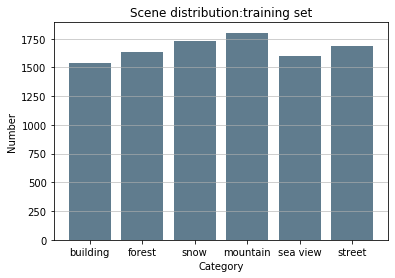

In [8]:
# Show the number of examples of each class

class_names=["building", "forest", "snow","mountain", "sea view", "street"]
class_count = [sum(train_data_label['label'] == i) for i in range(6)]

plt.bar(class_names, class_count,color='#607c8e')
plt.title('Scene distribution:training set')
plt.xlabel('Category')
plt.ylabel('Number')
plt.grid(axis='y', alpha=0.75)

# Load Image Data

In [9]:
def get_data(df, dirname):
    '''
    df: dataframe which includes image names and image labels
    dirname : the dir name which contains the images
    
    return :
        images : list of images, each image size is 3*150*150
        labels : list of labels
    '''

    transform_torch = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

    images = []

    for filename in df['image_name']:
        if not filename.endswith('.jpg'):
            continue
        image_path = os.path.join(dirname, filename)

        image = plt.imread(image_path)
        image = image.astype(np.float32)
        if image.shape != (150,150,3):
            image = transform.resize(image, (150,150,3))

        image = transform_torch(image)
        images.append(image)
    
    labels = list(df['label'])
    return images, labels

In [10]:
train_images, train_labels =get_data(train_data_label, 'data/train') 
test_images, test_labels =get_data(test_data_label, 'data/test') 

In [11]:
print('length of train images       : ',len(train_images))
print('length of train image labels : ',len(train_labels))

print('length of test images        : ',len(test_images))
print('length of test image labels  : ',len(test_labels))

length of train images       :  9999
length of train image labels :  9999
length of test images        :  1221
length of test image labels  :  1221


# Data Preprocessing

We use the DataLoader to define the batch of data which can accelerate the training.

In [12]:
class Dataset(th.utils.data.Dataset):
    '''
    My Dataset for the DataLoader
    '''
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

In [13]:
dataset = Dataset(train_images, train_labels)

my_train_loader = th.utils.data.DataLoader(
    dataset,
    batch_size=4,
    num_workers=2,
    shuffle=True)

# get some random training images
dataiter = iter(my_train_loader)
images = dataiter.next()

print('the shape of a batch : ', images[0].shape)

the shape of a batch :  torch.Size([4, 3, 150, 150])


In [14]:
# Write the function to easily get the DataLoader by input X and Y and batch size
def get_loader(x,y,batch_size,num_workers=1):
    dataset = Dataset(x, y)
    return th.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,shuffle=True)

# Baseline Model


### PyTorch functions to build the network

####  Forward propagation

In PyTorch, there are built-in functions that carry out the convolution steps for you.

- **nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0):** Convolution layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#conv2d)

- **nn.MaxPool2d(kernel_size, stride=None, padding=0):** Max pooling layer. You can read the full documentation [here](http://pytorch.org/docs/master/nn.html#maxpool2d)

- **F.relu(Z1):** computes the elementwise ReLU of Z1 (which can be any shape). You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#torch.nn.ReLU)

- **x.view(new_shape)**: Returns a new tensor with the same data but different size. It is the equivalent of numpy function *reshape* (Gives a new shape to an array without changing its data.). You can read the full documentation [here.](http://pytorch.org/docs/master/tensors.html#torch.Tensor.view)

- **nn.Linear(in_features, out_features):** Applies a linear transformation to the incoming data: $y = Ax + b$, it is also called a fully connected layer. You can read the full documentation [here.](http://pytorch.org/docs/master/nn.html#linear-layers)

#### Example of use of helper method get_output_size() 

Let's assume you have an *input volume of size 3x32x32* (where 3 is the number of channels)
and you use a 2D convolution with the following parameters:

```python
conv1 = nn.Conv2d(3, 18, kernel_size=7, stride=2, padding=1)
```
then, the size of the output volume is 18x?x? (because we have 18 filters) where ? is given by the convolution formulas (see above).

**get_output_size()** function allows to compute that size:

```
out_size = get_output_size(in_size=32, kernel_size=7, stride=2, padding=1)
print(out_size) # prints 14
```

That is to say, *the output volume is 18x14x14*

In [15]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

In [16]:
get_output_size(in_size=32, kernel_size=7, stride=2, padding=1)

14

###  Define a Convolution Neural Network

In [17]:
# Define our model architecture

class BaselineConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(BaselineConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x150x150 input image to a 16x75x75 volume)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 16x75x75 input image to a 32x36x36 volume)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 32x36x36 input image to a 32x18x18 volume)
        
        self.flatten = 32 * 18 * 18
        
        self.fc1 = nn.Linear(self.flatten, 64) 
        
        # Since there are 6 classes so the output of the last layer is 6
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x150x150 -> 16x150x150
        x = F.relu(self.conv1(x))
        # 16x150x150 -> 16x75x75
        x = self.pool1(x)
        
        # shape : 16x75x75 -> 32x75x75
        x = F.relu(self.conv2(x))
        # 32x75x75 -> 32x38x38
        x = self.pool2(x)
        
        # shape : 32x38x38 -> 32x38x38
        x = F.relu(self.conv3(x))
        # 32x38x38 -> 32x19x19
        x = self.pool3(x)
        
        # 32x19x19 
        x = x.view(-1, self.flatten)
        # 32x19x19  -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 6
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

### Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and ADAM (optionnaly SGD with momentum)



In [18]:

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer



### Train the network


We simply have to loop over our data iterator, and feed the inputs to the
network and optimize

#### Training loop

The training script: it takes ~10s per epoch with batch_size = 32

In [19]:
def train(net,x,y,val_x,val_y, batch_size=32, n_epochs=10, learning_rate=0.001):
    
    """
    Train a neural network and print statistics of the training
    
    :param  net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    
    train_loader = get_loader(x,y, batch_size)
    val_loader = get_loader(val_x,val_y, batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [20]:
net = BaselineConvolutionalNetwork()
train(net, train_images, train_labels,test_images, test_labels, 32, 2)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 2
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 7.74 took: 11.17s
Epoch 1, 20% 	 train_loss: 1.33 took: 10.57s
Epoch 1, 30% 	 train_loss: 1.20 took: 10.42s
Epoch 1, 40% 	 train_loss: 1.23 took: 10.31s
Epoch 1, 51% 	 train_loss: 1.19 took: 10.57s
Epoch 1, 61% 	 train_loss: 1.13 took: 10.54s
Epoch 1, 71% 	 train_loss: 1.13 took: 10.70s
Epoch 1, 81% 	 train_loss: 1.14 took: 10.70s
Epoch 1, 92% 	 train_loss: 1.05 took: 10.62s
Validation loss = 1.06
Epoch 2, 10% 	 train_loss: 1.07 took: 10.41s
Epoch 2, 20% 	 train_loss: 1.01 took: 10.45s
Epoch 2, 30% 	 train_loss: 0.96 took: 10.12s
Epoch 2, 40% 	 train_loss: 1.00 took: 10.03s
Epoch 2, 51% 	 train_loss: 0.99 took: 10.03s
Epoch 2, 61% 	 train_loss: 0.97 took: 10.02s
Epoch 2, 71% 	 train_loss: 1.02 took: 10.47s
Epoch 2, 81% 	 train_loss: 0.95 took: 10.96s
Epoch 2, 92% 	 train_loss: 0.92 took: 10.14s
Validation loss = 0.86
Training Finished, took 215.07s


([1.7754107247145412, 0.9532699071751616],
 [1.060309348962246, 0.8625926360105857])

Let us look at how the network performs on the whole test set.

In [21]:
def dataset_accuracy(net, x,y, name=""):
    test_batch_size = 4
    data_loader = get_loader(x,y,test_batch_size)
    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = th.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))


In [22]:
dataset_accuracy(net, test_images, test_labels)

Accuracy of the network on the 1221  images: 65.93 %


Seems like the network learnt something. Because the network has at least 17% accuracy (randomly picking a class out of 6 classes).

Let's see how it perform in each class

### Confusion Matrix

In [23]:

def accuracy_per_class(net, x,y):
    test_batch_size = 4
    data_loader = get_loader(x,y,test_batch_size)
    
    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    net = net.to(device)
    n_classes = 6
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in data_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = th.max(outputs.data, 1)
        for i in range(test_batch_size):
            if len(labels) <= i:
                break
            ll = labels[i]
            pp = predicted[i]
            confusion_matrix[ll, pp] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(class_names[i], percentage_correct))
    return confusion_matrix

def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Class      Accuracy (%)
building     72.28   
forest       79.06   
snow         81.50   
mountain     65.50   
sea view     24.77   
street       75.23   


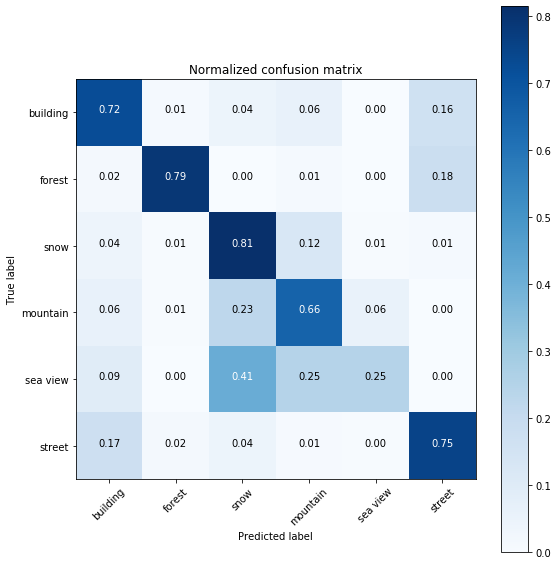

In [24]:

confusion_matrix = accuracy_per_class(net, test_images, test_labels)
plot_confusion_matrix(confusion_matrix, class_names, normalize=True,
                      title='Normalized confusion matrix')

The prediction

In [25]:
def predict(net, X):
    test_loader = th.utils.data.DataLoader(X,batch_size=4,num_workers=1,shuffle=False)

    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    net = net.to(device)
    res = []
    for images in test_loader:
        images = images.to(device)
        outputs = net(images)
        _, predicted = th.max(outputs, 1)
        res += list(predicted.numpy())
    return res


In [26]:
res = predict(net, test_images)
np.mean(res == test_data_label['label'])

0.6592956592956593

## Batch_Classifier

Everything is done here. There are simple data transformation and a version of a ResNet 18 implemented in PyTorch.

In [28]:
%%file submissions/starting_kit/batch_classifier.py

import numpy as np
from skimage import transform
import torch.nn as nn
import torch.optim as optim
import torch as th
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms

import time
import itertools
from sklearn.model_selection import train_test_split


class Dataset(th.utils.data.Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        
    def __getitem__(self, index):
        return self.images[index], self.labels[index]

    def __len__(self):
        return len(self.labels)


def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

def get_loader(x,y,batch_size,num_workers=1):
    dataset = Dataset(x, y)
    return th.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers,shuffle=True)


def train(net,x,y,val_x,val_y, batch_size=32, n_epochs=10, learning_rate=0.001):
    
    """
    Train a neural network and print statistics of the training
    
    :param  net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    
    you can define your 
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    device = th.device("cuda" if th.cuda.is_available() else "cpu")
    
    train_loader = get_loader(x,y, batch_size)
    val_loader = get_loader(val_x,val_y, batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
            for inputs, labels in val_loader:
                # Move tensors to correct device
                inputs, labels = inputs.to(device), labels.to(device)
                # Forward pass
                predictions = net(inputs)
                val_loss = criterion(predictions, labels)
                total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

class BaselineConvolutionalNetwork(nn.Module):
    '''
    For you to build your network architecture
    '''
    def __init__(self):
        super(BaselineConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 3x150x150 input image to a 16x75x75 volume)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 16x75x75 input image to a 32x36x36 volume)
        
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # cf comments in forward() to have step by step comments
        # on the shape (how we pass from a 32x36x36 input image to a 32x18x18 volume)
        
        self.flatten = 32 * 18 * 18
        
        self.fc1 = nn.Linear(self.flatten, 64) 
        self.fc2 = nn.Linear(64, 6)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x150x150 -> 16x150x150
        x = F.relu(self.conv1(x))
        # 16x150x150 -> 16x75x75
        x = self.pool1(x)
        
        # shape : 16x75x75 -> 32x75x75
        x = F.relu(self.conv2(x))
        # 32x75x75 -> 32x38x38
        x = self.pool2(x)
        
        # shape : 32x38x38 -> 32x38x38
        x = F.relu(self.conv3(x))
        # 32x38x38 -> 32x19x19
        x = self.pool3(x)
        
        # 32x19x19 
        x = x.view(-1, self.flatten)
        # 32x19x19  -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 6
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x



class Classifier(object):
    """
    gen_train, gen_valid... shouldn't be modified
    You can change the rest like criterion, optimizer or even the function _build_model if you want to
    
    Accuracy on train and valid during the epochs are on data that are part of the train data for the
    RAMP challenge, so you shouldn't expect to see the same values.
    """
    def __init__(self):
        self.net = BaselineConvolutionalNetwork()
        self.epochs = 1
        self.batch_size = 32

    def fit(self, train_x, train_y):
        X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=42)
        
        train_history, val_history = train(self.net, X_train, y_train,X_val, y_val, self.batch_size, self.epochs)


    def predict_proba(self, X):
        # do not modify this function
        test_loader = th.utils.data.DataLoader(X,batch_size=4,num_workers=1,shuffle=False)

        device = th.device("cuda" if th.cuda.is_available() else "cpu")
        self.net = self.net.to(device)
        res = []
        for images in test_loader:
            images = images.to(device)
            outputs = self.net(images)
            _, predicted = th.max(outputs, 1)
            res += list(predicted.numpy())
        results = np.zeros((len(X), 6))
        for i in range(len(res)):
            results[i, res[i]] = 1
        return results


# Test Local Submission

In [29]:
!ramp_test_submission

Testing Scene Classification
Reading train and test files from ./data ...
Reading cv ...
Training submissions/starting_kit ...
CV fold 0
===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 1
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 12.97 took: 7.76s
Epoch 1, 21% 	 train_loss: 1.60 took: 7.29s
Epoch 1, 31% 	 train_loss: 1.54 took: 7.42s
Epoch 1, 42% 	 train_loss: 1.49 took: 7.42s
Epoch 1, 52% 	 train_loss: 1.52 took: 7.04s
Epoch 1, 63% 	 train_loss: 1.43 took: 7.25s
Epoch 1, 73% 	 train_loss: 1.43 took: 6.94s
Epoch 1, 84% 	 train_loss: 1.36 took: 6.98s
Epoch 1, 94% 	 train_loss: 1.37 took: 6.96s
Validation loss = 1.33
Training Finished, took 76.85s
test len 9999
test len 1221
	score   acc  balanced_acc       time
	train  0.49          0.38  82.524745
	valid  0.44          0.33  44.888390
	test   0.44          0.33   5.875787
CV fold 1
===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 1
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 10.54 took: 7.56s
Epoch 1, 21% 	 train_loss

# More Information

You can find more information in the [README](www.google.com) of the [ramp workflow lib](www.google.com) 